In [117]:
import pandas as pd
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

def decomposition(data, model):
    data = pd.DataFrame(model.fit_transform(data))
    return data

def normalization(data, model):
    data = pd.DataFrame(model.fit_transform(data))
    return data

def get_two_humped_camel(pred, pred_prob, test_target, count_step):
    answer = (pred == test_target)
    step = 1 / count_step
    steps = np.cumsum([step]*count_step)
    correct = []
    wrong = []
    for i in steps:
        ppp = np.array(answer)[(pred_prob < i) & (pred_prob > i - step)]
        correct.append(sum(ppp == True))
        wrong.append(sum(ppp == False))
    return correct, wrong, steps

def get_metrics(y_test, y_pred, y_prob):
    if len(y_pred) != 0:
        r3 = lambda x: round(x, 3)
        ac = r3(metrics.accuracy_score(y_test, y_pred))
        f1 = r3(metrics.f1_score(y_test, y_pred, pos_label=0)), r3(metrics.f1_score(y_test, y_pred))
        recall = r3(metrics.recall_score(y_test, y_pred, pos_label=0)), r3(metrics.recall_score(y_test, y_pred))
        precision = (r3(metrics.precision_score(y_test, y_pred, pos_label=0)),
                    r3(metrics.precision_score(y_test, y_pred)))
        roc_auc = r3(metrics.roc_auc_score(y_test, y_prob[:,1]))
        fpr, tpr = metrics.roc_curve(y_test, y_prob[:,1])[:2]
        return ac, f1, recall, precision, roc_auc, fpr, tpr
    else:
        return [None]*7

    
def go_to_perc(y_test, y_pred, y_prob, perc):
    indices_to_hold = []
    for i in range(len(y_prob)):
        if y_prob[i][0] >= perc or y_prob[i][0] <= 1 - perc:
            indices_to_hold.append(i)
    return y_test[indices_to_hold], y_pred[indices_to_hold], y_prob[indices_to_hold]

def table(table_names, names, values, n_p, v_p, left=6, width=39, between = 12):
    
    fill = lambda string: string + (width+1 - len(string)) * ' ' + '|'
    horizontal_line = ' '*left + "-"*width + between*' ' +  '-'*width
    table_names_row = ' '*(left-1) +fill(f"| {table_names[0]}") + (between-2)*' ' + fill(f"| {table_names[1]}")
    rows = [' '*(left-1)+fill(f"| {names[i]}     = {values[i]}")+(between-2)*' '+fill(f"| {n_p[i]}     = {v_p[i]}")
                                                                                       for i in range(len(names))]
    print(horizontal_line,
          table_names_row,
          horizontal_line,
          *rows,
          horizontal_line, sep='\n')

def get_name(model):
    if 'catboost' in str(model):
        return "CatBoostClassifier"
    elif "__main__" in str(model):
        return "CustomModel"
    else:
        return str(model)[:str(model).find('(')]

def get_model_info(model, data, target, train, test=None, decomposition_model=None,
                   normilization_model=None, perc=0.5, output=True, graphics = True, return_=None):
    if test == None:
        test = data[train:].shape[0]
    if decomposition_model != None:
        data = decomposition(data, decomposition_model)
    if normilization_model != None :
        data = normalization(data, normilization_model)
    
    name = get_name(model)
    X_train, y_train = np.array(data[:train]), np.array(target[:train])
    X_test , y_test  = np.array(data[train:train+test]), np.array(target[train:train+test])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    ac, f1, recall, precision, roc_auc, fpr, tpr = get_metrics(y_test, y_pred, y_prob)
    
    if perc == 0.5:
        y_test_p, y_pred_p, y_prob_p = y_test, y_pred, y_prob
        ac_p, f1_p, recall_p, precision_p, roc_auc_p, fpr_p, tpr_p = ac, f1, recall, precision, roc_auc, fpr, tpr
    else:
        y_test_p, y_pred_p, y_prob_p = go_to_perc(y_test, y_pred, y_prob, perc)
        ac_p, f1_p, recall_p, precision_p, roc_auc_p, fpr_p, tpr_p = get_metrics(y_test_p, y_pred_p, y_prob_p)
        
    names = ['accuracy  ', 'precision ', 'recall    ', 'f1_score  ', 'roc_auc   ', 'true_pred ', 'len_pred  ']
    values = [ac, precision, recall, f1, roc_auc, int(len(y_test)*ac), len(y_test)]
    n_p = names
    v_p = [ac_p, precision_p, recall_p, f1_p, roc_auc_p, int(len(y_test_p)*ac_p), len(y_test_p)]
    
    if output == True:    
        table([name, name+f' perc={perc}'], names, values, n_p, v_p)
    
    if graphics == True:
        fig, (ax1, ax2) = plt.subplots(ncols=2, nrows = 1, figsize = (14, 5))
        ax1.set_title('Receiver Operating Characteristic')
        ax1.plot([0.0,1.0], [0.0,1.0], linestyle='dashed', c='r', label='full random ROC')
        ax1.plot(fpr, tpr, c='b', label = name)
        ax1.grid()
        ax1.set_ylabel('True Positive Rate')
        ax1.set_xlabel('False Positive Rate')
        if perc != 0.5:
            ax1.plot(fpr_p, tpr_p, c='g', label = name+f' perc {perc}')
            ax1.legend(loc = 'lower right')
        correct, wrong, steps = get_two_humped_camel(y_pred, y_prob[:,1], list(y_test), count_step=10)
        ax2.plot(steps, correct, label='Correct', c = 'g')
        ax2.plot(steps, wrong, label='Wrong', c = 'r')
        ax2.grid()
        ax2.legend()
    
    if return_ == True:
        return {'model':model,
                'decomposition_model':decomposition_model,
                'normalization_model':normilization_model,
                'perc':perc,
                'train_shape':train,
                'len_y_test': len(y_test),
                'true_pred' :int(len(y_test)*ac),
                'ac':ac,
                'f1':f1,
                'recall':recall,
                'precision':precision,
                'roc_auc':roc_auc,
                'len_y_test_p':len(y_test_p),
                'true_pred_p':int(len(y_test_p)*ac),
                'ac_p':ac_p,
                'f1_p':f1_p,
                'recall_p':recall_p,
                'precision_p':precision_p,
                'roc_auc_p':roc_auc_p}
        

# Example

      ---------------------------------------            ---------------------------------------
     | KNeighborsClassifier                  |          | KNeighborsClassifier perc=0.6         |
      ---------------------------------------            ---------------------------------------
     | accuracy       = 0.548                |          | accuracy       = 0.628                |
     | precision      = (0.532, 0.582)       |          | precision      = (0.63, 0.623)        |
     | recall         = (0.727, 0.372)       |          | recall         = (0.797, 0.417)       |
     | f1_score       = (0.614, 0.454)       |          | f1_score       = (0.704, 0.5)         |
     | roc_auc        = 0.598                |          | roc_auc        = 0.689                |
     | true_pred      = 548                  |          | true_pred      = 162                  |
     | len_pred       = 1000                 |          | len_pred       = 258                  |
      ----------------

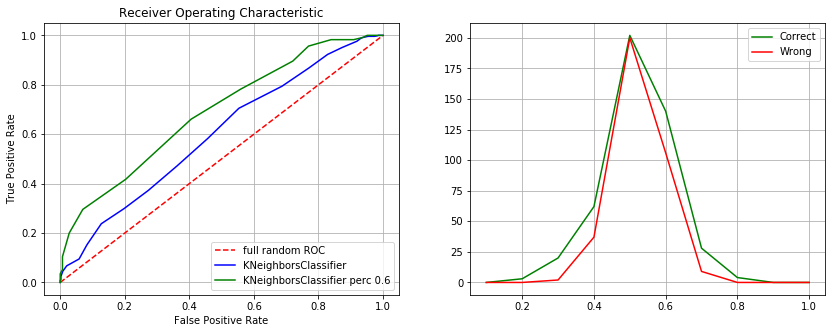

In [118]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

data = pd.read_csv('data5433v2.csv')
target = data.target
data = data.drop('target', axis=1)

history = get_model_info(model=KNeighborsClassifier(n_neighbors=50), 
                         data=data, target=target, train=4433, test=1000, 
                         decomposition_model=PCA(20),
                         perc=0.6, return_=True)

In [116]:
print(f'model = {history["model"]}', 
      f'decomposition_model = {history["decomposition_model"]}',
      f'normalization_model = {history["normalization_model"]}', sep = '\n')

model = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')
decomposition_model = PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)
normalization_model = None
